In [1]:
import pandas as pd
import numpy as np


# pymc3 with theano backend
import pymc3 as pm
import theano.tensor as tt

import scipy.stats as stats
import matplotlib.pyplot as plt

import datetime
import collections

# finance data from yahoo finance
import yfinance as yf

# silence warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# modify figure size
from IPython.core.pylabtools import figsize

# define fonts

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 19}

plt.rc('font', **font)

In [118]:
# same stock as previously

# finance
fin = ["IDCBY",
"HSBC",
"C",
"V",
"JPM",
"MA",
"BAC",
"IDCBF"]

# Healthcare
health = ["JNJ",
"RHHVF",
"NVS",
"MRK",
"PFE",
"ABT",
"BMY",
"MDT" ]

# Consumer goods
cons = ["AAPL",
"NSRGF",
"PG",
"PEP",
"TSM",
"INTC",
"KO",
"LVMUY"]

# Services
srv = ["AMZN",
"NFLX",
"WMT",
"UNH",
"HD",
"DIS",
"CMCSA",
"CHLKF"]

# Utilities
util = ["CVX",
"NEE",
"IBDRY",
"OJSCY",
"DUK",
"D",
"SO",
"AEP"]

#TECH
tech = ["MSFT",
"GOOGL",
"FB",
"VOD",
"ACN",
"T",
"CHT",
"VZ"]

# Industrial goods
ind = ["UTX",
"HON",
"LMT",
"EADSY",
"GE",
"SIEGY",
"MMM",
"CAT"]

# Random
others = ["XOM",
"BUD",
"NVO",
"BA",
"USB",
"IBM",
"ORCL",
"WFC"]

In [119]:
# combine stock information
stocks = fin+health+srv+ind+cons+util+tech+others

stock_dict = {'HEALTH':health,'IND':ind, 'UTIL':util,'FINANCE':fin,'TECH':tech,'SERVICE':srv,'CONSUM':cons,'OTHERS':others}

# back tranlation
stock_2_theme = {}
for key, val in stock_dict.items():
    for v in val:
        stock_2_theme[v] = key
    
# choose colors for the plots
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821","#345eeb", "#eb8f34", "#57514b", "#10d4de"]

stock_closes = pd.DataFrame()

enddate = "2019-02-22" #  ends one year ago 
startdate = '2014-1-1'

In [9]:
n_observations = 100 

In [10]:
# fetch stock information
for stock in stocks:
    tickerData = yf.Ticker(stock)
    x = tickerData.history(period='1d', start=startdate, end=enddate)
    stock_series = pd.Series(x['Close'].astype(float), name=stock)
    stock_closes[stock] = stock_series

In [11]:
stock_closes.columns

Index(['IDCBY', 'HSBC', 'C', 'V', 'JPM', 'MA', 'BAC', 'IDCBF', 'JNJ', 'RHHVF',
       'NVS', 'MRK', 'PFE', 'ABT', 'BMY', 'MDT', 'AMZN', 'NFLX', 'WMT', 'UNH',
       'HD', 'DIS', 'CMCSA', 'CHLKF', 'UTX', 'HON', 'LMT', 'EADSY', 'GE',
       'SIEGY', 'MMM', 'CAT', 'AAPL', 'NSRGF', 'PG', 'PEP', 'TSM', 'INTC',
       'KO', 'LVMUY', 'CVX', 'NEE', 'IBDRY', 'OJSCY', 'DUK', 'D', 'SO', 'AEP',
       'MSFT', 'GOOGL', 'FB', 'VOD', 'ACN', 'T', 'CHT', 'VZ', 'XOM', 'BUD',
       'NVO', 'BA', 'USB', 'IBM', 'ORCL', 'WFC'],
      dtype='object')

In [12]:
# normalization by delta percentage
stock_returns = stock_closes.pct_change()[1:][-n_observations:]

# list the stock indices
stock_returns.columns

Index(['IDCBY', 'HSBC', 'C', 'V', 'JPM', 'MA', 'BAC', 'IDCBF', 'JNJ', 'RHHVF',
       'NVS', 'MRK', 'PFE', 'ABT', 'BMY', 'MDT', 'AMZN', 'NFLX', 'WMT', 'UNH',
       'HD', 'DIS', 'CMCSA', 'CHLKF', 'UTX', 'HON', 'LMT', 'EADSY', 'GE',
       'SIEGY', 'MMM', 'CAT', 'AAPL', 'NSRGF', 'PG', 'PEP', 'TSM', 'INTC',
       'KO', 'LVMUY', 'CVX', 'NEE', 'IBDRY', 'OJSCY', 'DUK', 'D', 'SO', 'AEP',
       'MSFT', 'GOOGL', 'FB', 'VOD', 'ACN', 'T', 'CHT', 'VZ', 'XOM', 'BUD',
       'NVO', 'BA', 'USB', 'IBM', 'ORCL', 'WFC'],
      dtype='object')

In [13]:
# reduce autocorrelation by thinning data 
blocks = 5
block_dict = {}
for n in range(blocks):
    idx = [(it * blocks)+n for it in range(stock_returns.shape[0]// blocks) ]
    
    block_dict[n] = stock_closes.iloc[idx] # use stock close data
    
    block_dict[n] = block_dict[n].pct_change()[1:][-n_observations:] # convert to weekwise delta

In [14]:
# choose a block for preparation
prep_stock = block_dict[2]

In [15]:
def cov_to_corr(A):
    """
    Transform covariance to correlation
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    return A

In [16]:
# choose a stock to begin with
# we will use the stock with the highest average return per day.
seed_share = pd.DataFrame(stock_returns.sum().sort_values(ascending=False) ).iloc[0].name

# For the time period chosen that was PG, which is in the group Consumer goods

In [17]:
stem_shares =  pd.DataFrame(stock_returns  
                            .corr()[seed_share] # correlation to the seed
                            .sort_values()) # sort

In [19]:
stem_shares = stem_shares.index.to_series().map(stock_2_theme) # add information on group

stem_shares = pd.DataFrame(stem_shares.drop_duplicates()) # remove additional shares

In [21]:
# the most highly correlated shares by subject group
stem_shares = stem_shares.loc[stem_shares[0] != stock_2_theme[seed_share]]

In [22]:
test_portfolio = stem_shares.index.tolist() + [seed_share ] # extend by seed

In [23]:
test_portfolio

['IDCBF', 'CHLKF', 'OJSCY', 'EADSY', 'CHT', 'NVO', 'BMY', 'PG']

In [33]:
def generate_portfolio(seed, exclusions = []):
    
    """
    Seed STR :  stock index to base the portfolio upon
    exlusions LIST :list of stock options disregarded from sampling
    
    returns:
    list of stock options
    """
    
    stem_shares =  pd.DataFrame(stock_returns  
                            .corr()[seed_share] # correlation to the seed
                            .sort_values()) # sort
    
    stem_shares = stem_shares.index.to_series().map(stock_2_theme) # add information on group
    
    stem_shares = stem_shares.loc[~ stem_shares.index.to_series().isin(exclusions)]# remove forbidden shares
    
    stem_shares = pd.DataFrame(stem_shares.drop_duplicates()) # remove additional shares
    
    
    # the most highly correlated shares by subject group
    stem_shares = stem_shares.loc[stem_shares[0] != stock_2_theme[seed_share]]
    
    return stem_shares.index.tolist() + [seed_share ]

def specific_stock(combination):
    
    """
    combination LIST: list of specific stock options
    """
    
    
    priormus = [] 
    priorstd = []
    
    for i, (key, val) in enumerate(stock_dict.items()):
        priormus.append(prior_expectations[key][0])
        priorstd.append(prior_expectations[key][1])
        
    stock_relevant = stock_returns[combination]
    covar = stock_relevant.cov()
    return stock_relevant, np.asarray(covar), np.array(priormus), np.array(priorstd)

def calculate_posterior(portfolio ):
    """
    create posterior mu and covariance 
    """
    
    blocktrace = {}

    # we have 5 subsets to analyze the data on after thinning the data above
    for block, block_data in block_dict.items():

        stock_returns = pd.DataFrame(block_data)

        stocks_chosen, init, prior_mu, prior_std = specific_stock(test_portfolio)

        with pm.Model() as model:
    
            covar = pm.WishartBartlett('covar', np.diag(prior_std**2), nu=16, testval=init)
    
            mu = pm.Normal('returns', mu=prior_mu, sd=1, shape= prior_mu.shape[0] )

            obs = pm.MvNormal('observed returns', mu=mu, cov = covar, observed=stocks_chosen)
    
            step = pm.NUTS()
            trace = pm.sample(10000, step=step)
        
            blocktrace[block] = trace
        
    return blocktrace

In [25]:
# again we need priors
prior_expectations = {}
for ind, stocks in stock_dict.items():#[health,ind, util,fin,tech,srv,cons,others]:
    prior_expectations[ind] = (stock_returns[stocks].mean(axis=1).mean() , stock_returns[stocks].mean(axis=1).std())
    #print(ind, stock_returns[stocks].mean(axis=1).mean() , stock_returns[stocks].mean(axis=1).std()  )

In [34]:
blocktrace = calculate_posterior(test_portfolio)

Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:14<00:00, 563.74draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 1 divergences: 100%|██████████| 42000/42000 [01:14<00:00, 562.42draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:16<00:00, 548.16draws/s]
Added new variable covar_c to model diagonal of Wishart

In [99]:

def combine_blocktrace(blocktrace):
    # burn 50 % and combine the blocks of mu
    mu_samples = [trace["returns"][:int(trace["returns"].shape[0]/2)] for block, trace in blocktrace.items()]
    mu_samples = np.concatenate(mu_samples, axis=0)
    
    # and covar
    cov_samples = [trace["covar"][:int(trace["covar"].shape[0]/2)] for block, trace in blocktrace.items()]
    cov_samples = np.concatenate(cov_samples, axis=0)
    
    return mu_samples, cov_samples

In [105]:

def plot_mus(mu_samples):

    figsize(14,6)

    #examine the mean return first.
    
    for i in range(8):
        plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
                histtype="stepfilled", normed=True, 
             label = "%s" % test_portfolio[i])

    plt.vlines(mu_samples.mean(axis=0), 0, 150, linestyle="--", linewidth = .5 )
    plt.title("Posteriore Verteilung des $\mu$ pro Woche ")
    plt.legend();
    
def plot_covar(cov_samples):
    figsize(20,7)
    
    mean_covariance_matrix = cov_samples.mean(axis=0)

    correlation = cov_to_corr(mean_covariance_matrix)

    plt.subplot(1,2,1)
    plt.imshow(correlation , interpolation="none", 
                cmap = "Reds") 
    plt.xticks(np.arange(8), test_portfolio,rotation='vertical')
    plt.yticks(np.arange(8), test_portfolio)
    plt.colorbar(orientation="vertical")
    plt.title("Mittlere ( posteriore) Korrelationsmatrix")

    plt.subplot(1,2,2)
    plt.bar(np.arange(8), np.sqrt(np.diag(mean_covariance_matrix)),
        color = colors[2], alpha = 0.7)
    plt.xticks(np.arange(8) + 0.5, test_portfolio,rotation='vertical');
    plt.title("Mittlere ( posteriore) Standardabweichung der wöchentlichen Änderungen")

    plt.tight_layout();

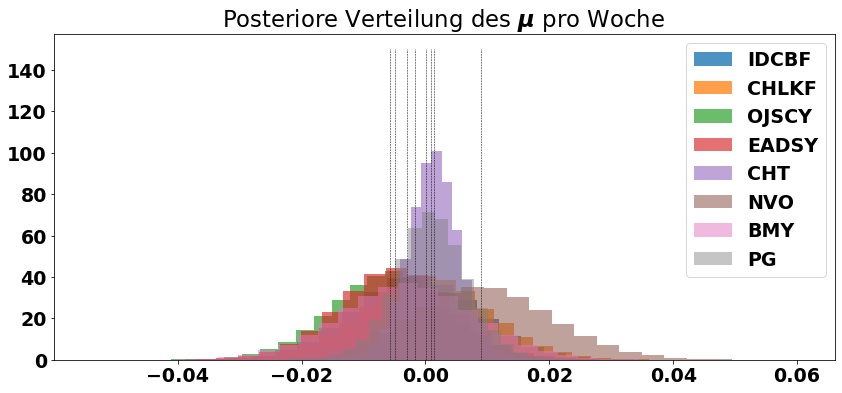

In [106]:
plot_mus(mu_samples)

In [ ]:
np.stack([trace["covar"] for block, trace in blocktrace.items()] ).shape

In [88]:
cov_samples.shape

(100000, 8, 8)

In [112]:
def replace_highest_corr(covariance_matrix, portfolio):
    """
    find the stock with the highest covariance and replace it
    """
    
    mean_covariance_matrix = covariance_matrix.mean(axis=0)
    # first fill the diagonals with 0
    np.fill_diagonal(mean_covariance_matrix, 0)
    
    # choose lowest covariance
    lowest_covar = np.where(mean_covariance_matrix == np.amax(mean_covariance_matrix))

    # covatiance is between pairs. so replace the entity with lower mean 
    lowest_mean = np.mean(mu_samples[[lowest_covar]] , axis=2)
    
    # find highest offender, return
    return portfolio[ lowest_covar[np.where(lowest_mean == np.amin(lowest_mean))[0][0]][0] ] # np.mean(mu_samples[[lowest_covar]] , axis=2)

In [96]:
replace_highest_corr(cov_samples)

In [457]:
excluded = []

In [455]:
seed_share = 'PG'

In [458]:
generate_portfolio(seed_share ,excluded)

['FB', 'NFLX', 'BAC', 'NEE', 'PFE', 'NVO', 'EADSY', 'PG']

In [529]:
mu_development = []
cov_development = []

for count , n in enumerate(range(4)):
    print(excluded)
    
    portfolio = generate_portfolio(seed_share ,excluded)
    
    blocktrace = calculate_posterior(portfolio)
    
    mu_samples, cov_samples = combine_blocktrace(blocktrace)
    
    excluded.append(replace_highest_corr(cov_samples,portfolio))
    
    
    
    #plot_mus(mu_samples)
    #plot_covar(cov_samples)
    
    print(f"iteration {count} ")
    print(portfolio)
    
    mu_development.append(mu_samples)
    cov_development.append(cov_samples)


['NVO']


Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:15<00:00, 555.70draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:14<00:00, 563.06draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:14<00:00, 561.16draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess samp

iteration 0 
['FB', 'NFLX', 'BAC', 'NEE', 'PFE', 'EADSY', 'BUD', 'PG']
['NVO', 'EADSY']


Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:13<00:00, 573.51draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:15<00:00, 554.84draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:15<00:00, 553.14draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess samp

iteration 1 
['FB', 'NFLX', 'BAC', 'NEE', 'PFE', 'LMT', 'BUD', 'PG']
['NVO', 'EADSY', 'LMT']


Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:16<00:00, 548.42draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:16<00:00, 549.60draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:17<00:00, 540.54draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess samp

iteration 2 
['FB', 'NFLX', 'BAC', 'NEE', 'PFE', 'SIEGY', 'BUD', 'PG']
['NVO', 'EADSY', 'LMT', 'BUD']


Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 1 divergences: 100%|██████████| 42000/42000 [01:14<00:00, 565.50draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:13<00:00, 569.80draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:14<00:00, 563.45draws/s]
Added new variable covar_c to model diagonal of Wishart

iteration 3 
['FB', 'NFLX', 'BAC', 'NEE', 'PFE', 'SIEGY', 'USB', 'PG']


In [511]:
start_date = '2019-02-25'
end_date   = '2019-12-02'

In [528]:
#portfolio = ['FB', 'NFLX', 'BAC', 'NEE', 'PFE', 'LMT', 'BUD', 'PG']


In [513]:
def calculate_returns(portfol, invest, start_date, end_date):
    stocks_set = stock_closes_test[portfol]
    start_stocks = stocks_set.loc[stocks_set.index.to_series() == start_date].iloc[0]
    end_stocks = stocks_set.loc[stocks_set.index.to_series() == end_date].iloc[0]
    profit =  end_stocks - start_stocks
    
    profit_perc = profit/stocks_set.loc[stocks_set.index.to_series() == start_date].iloc[0]
    
    return (profit_perc*invest).sum()
    
    
    

In [530]:
calculate_returns(portfolio, (10000/8), start_date, end_date )

1273.5184872621526

In [543]:
mus = mu_samples.mean(axis=0)
covars = cov_samples.mean(axis=0)

In [565]:
mus.shape

(100000, 8)

In [575]:
mus = mu_development[3].mean(axis=0)
covars = cov_development[3].mean(axis=0)

In [576]:
wealth = mus*100 # initialize wealth with the posterior mu ratio

In [594]:
# optimize the investment
import scipy.optimize as opt

def optweight(wealth):
    #risk = 2
    return 1/8 * np.sum(np.matrix(mus).T * wealth  - (1* np.sum( wealth* covars , axis=0 ) ) )


# define constraint: sum(weights) = 1
fconst = lambda w: 1 - sum(w)
cons   = ({'type':'eq','fun':fconst})

# set bounds
bounds = [(0,0.3) for n in range(8)]



In [595]:
optimized = opt.minimize(optweight, x0=wealth, bounds= bounds, constraints = cons)

In [596]:
optimized

     fun: -0.0038935186478089388
     jac: array([-0.00341381, -0.00309958, -0.00265756, -0.00372776, -0.00150031,
       -0.00379888, -0.0045678 , -0.00151305])
 message: 'Optimization terminated successfully.'
    nfev: 110
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([1.25083508e-01, 9.22332083e-02, 9.70001089e-03, 1.72983273e-01,
       2.79547978e-16, 3.00000000e-01, 3.00000000e-01, 2.29715335e-16])

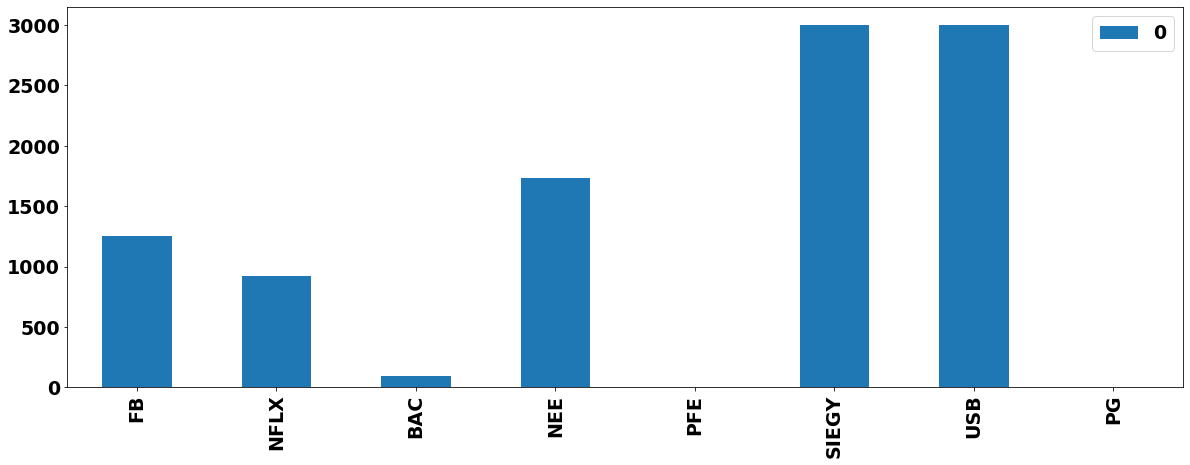

In [597]:
pd.DataFrame(optimized.x * 10000, index=portfolio ).plot(kind='bar')

In [598]:
invest = optimized.x * 10000

In [599]:
calculate_returns(portfolio, invest, start_date, end_date)

1678.1672517911811

In [ ]:
calculate_returns(portfolio, invest, start_date, end_date)

# testing the portfolio

In [ ]:
# lets get the data for 2019

In [335]:
import random

In [120]:
startdate = "2019-02-22" #  starts one year ago 
enddate = '2020-01-01' # ends beginning of the year
stock_closes_test = pd.DataFrame()

# fetch stock information
for stock in stocks:
    tickerData = yf.Ticker(stock)
    x = tickerData.history(period='1d', start=startdate, end=enddate)
    stock_series = pd.Series(x['Close'].astype(float), name=stock)
    stock_closes_test[stock] = stock_series

In [602]:
#background 100 random portfolios
random_profits = []
for n in range(1000):
    port = [ random.choice(stocks) for n  in range(8)] 
    random_profits.append(calculate_returns(port,(10000/8), start_date, end_date  ))

In [604]:
np.mean(random_profits)

1447.9243724967873